# MIMIC-III database

Analyzing PATIENTS, ADMISSIONS and DIAGNOSES_ICD tables.

Obs.: CAREGIVERS are linked with CHARTEVENTS table through CGID.


In [0]:
# Imports
from IPython.display import Image
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager

import seaborn as sns

# Colab
import io

%matplotlib inline

In [0]:
# READ CSV - Method 1 (Upload local files)
from google.colab import files
uploaded = files.upload()

In [142]:
# READ CSV - Method 2 (Drive)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### PLOT CONFIG

In [0]:
plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=11

### MIMIC-III SCHEMA

ER-Diagram: https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/data_viz/01_data_viz_basic.ipynb


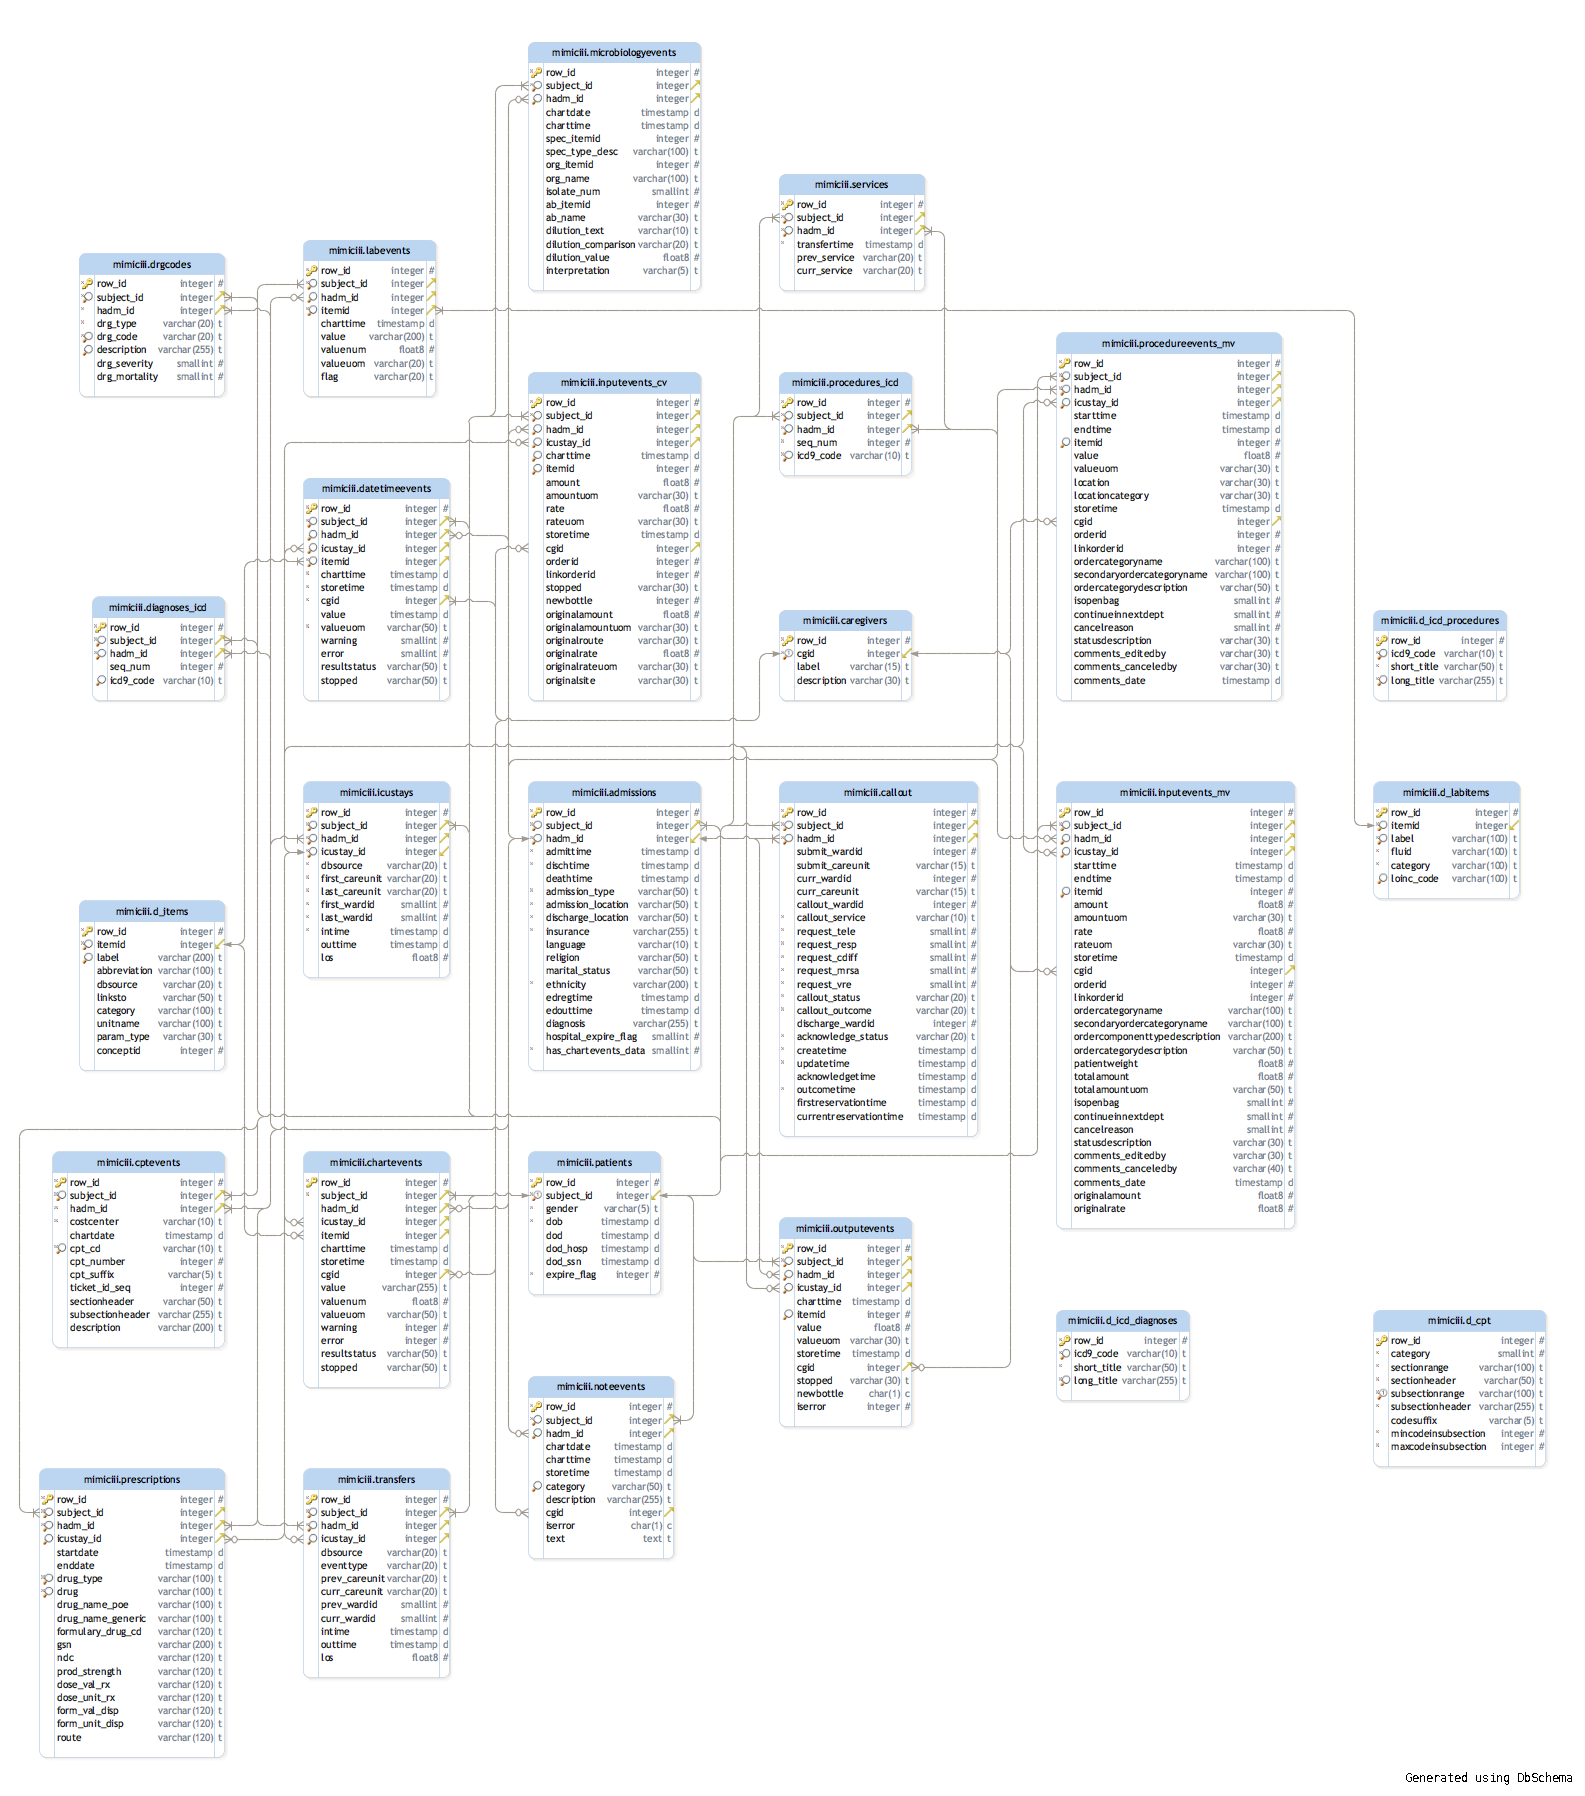

In [168]:
Image(filename = "/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/img/er_mimic.png", width=1000, height=1000)

### 1. PATIENTS TABLE


In [0]:
# Drive path
mimic_patients_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/PATIENTS.csv')

# Local path
# mimic_patients_df = pd.read_csv(io.BytesIO(uploaded['PATIENTS.csv']))

mimic_patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [0]:
# Total patients
print("Total patients: " + str(mimic_patients_df.GENDER.count()))

# Total from each gender
mimic_patients_df.GENDER.value_counts()

Total patients: 46520


M    26121
F    20399
Name: GENDER, dtype: int64

In [0]:
# Pizza plot :(

# patients_by_gender = mimic_patients_df.groupby(['GENDER']).count()['ROW_ID'].plot(kind='pie', autopct='%1.0f%%', 
#                                                                                   shadow=False, startangle=0, pctdistance=1.2, 
#                                                                                   labeldistance=1.4)
# patients_by_gender.axis('equal')
# patients_by_gender.legend(bbox_to_anchor=(1.0, 0.8))

In [0]:
def countplot_frenquency(df, column_name, title, order=None):
  ax = sns.countplot(x=column_name, data=df, order=order)
  plt.title(title)

  # Make twin axis
  ax2=ax.twinx()

  # Switch so count axis is on right, frequency on left
  ax2.yaxis.tick_left()
  ax.yaxis.tick_right()

  # Also switch the labels over
  ax.yaxis.set_label_position('right')
  ax2.yaxis.set_label_position('left')

  ax2.set_ylabel('Frequency [%]')

  ncount = len(df)
  for p in ax.patches:
      x=p.get_bbox().get_points()[:,0]
      y=p.get_bbox().get_points()[1,1]
      ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

  # Use a LinearLocator to ensure the correct number of ticks
  ax.yaxis.set_major_locator(mtick.LinearLocator(11))

  # Fix the frequency range to 0-100
  ax2.set_ylim(0,100)
  ax.set_ylim(0,ncount)

  # And use a MultipleLocator to ensure a tick spacing of 10
  ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))

  # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
  ax2.grid(None)
  return ax

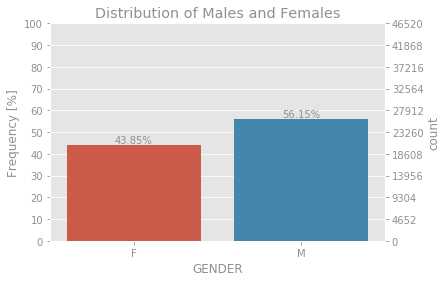

In [0]:
# Gender distribution
countplot_frenquency(mimic_patients_df, 'GENDER', 'Distribution of Males and Females')

### 2. ADMISSIONS TABLE

In [143]:
# Drive path
mimic_admission_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/ADMISSIONS.csv')

# Local path
# mimic_admission_df = pd.read_csv(io.BytesIO(uploaded['ADMISSIONS.csv']))

mimic_admission_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [0]:
# Total admissions
mimic_admission_df.count()

ROW_ID                  58976
SUBJECT_ID              58976
HADM_ID                 58976
ADMITTIME               58976
DISCHTIME               58976
DEATHTIME                5854
ADMISSION_TYPE          58976
ADMISSION_LOCATION      58976
DISCHARGE_LOCATION      58976
INSURANCE               58976
LANGUAGE                33644
RELIGION                58518
MARITAL_STATUS          48848
ETHNICITY               58976
EDREGTIME               30877
EDOUTTIME               30877
DIAGNOSIS               58951
HOSPITAL_EXPIRE_FLAG    58976
HAS_CHARTEVENTS_DATA    58976
dtype: int64

In [0]:
# Type
mimic_admission_df.ADMISSION_TYPE.value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [0]:
# Admission Location
mimic_admission_df.ADMISSION_LOCATION.value_counts()

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER FROM HOSP/EXTRAM     8456
TRANSFER FROM SKILLED NUR      273
** INFO NOT AVAILABLE **       204
HMO REFERRAL/SICK              102
TRANSFER FROM OTHER HEALT       71
TRSF WITHIN THIS FACILITY        5
Name: ADMISSION_LOCATION, dtype: int64

In [0]:
# Discharge Location
mimic_admission_df.DISCHARGE_LOCATION.value_counts()

HOME                         18962
HOME HEALTH CARE             13963
SNF                           7705
REHAB/DISTINCT PART HOSP      6429
DEAD/EXPIRED                  5854
LONG TERM CARE HOSPITAL       2305
SHORT TERM HOSPITAL           1534
DISC-TRAN CANCER/CHLDRN H      669
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   402
LEFT AGAINST MEDICAL ADVI      365
HOSPICE-MEDICAL FACILITY       153
HOME WITH HOME IV PROVIDR       67
OTHER FACILITY                  63
ICF                             47
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: DISCHARGE_LOCATION, dtype: int64

#### MERGE: PATIENTS AND ADMSSIONS TABLE

In [0]:
ap = pd.merge(mimic_admission_df, mimic_patients_df, on = 'SUBJECT_ID' , how = 'inner')

#### AGE CALCULATION

In [0]:
ages_df = ap

# ADMITTIME and DOB objects to datetime
ages_df["ADMITTIME"] = pd.to_datetime(ages_df["ADMITTIME"], format='%Y%m%d %H:%M:%S')
ages_df["DOB"] = pd.to_datetime(ages_df["DOB"], format='%Y%m%d %H:%M:%S')

In [0]:
ages_df["AGES"] = ages_df["ADMITTIME"].sub(ages_df["DOB"]).dt.days/365.242

# Adult patients only
ages_df = ages_df[(ages_df.AGES >= 18)]
print(ages_df.SUBJECT_ID.nunique())

# From each gender
patients_by_gender = ages_df.groupby('GENDER')['SUBJECT_ID'].nunique()
patients_by_gender

36560


GENDER
F    15438
M    21122
Name: SUBJECT_ID, dtype: int64

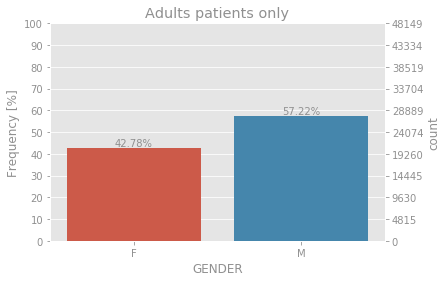

In [0]:
# Gender distribution: only adults
countplot_frenquency(ages_df, 'GENDER', 'Adults patients only')

In [0]:
# Median age: total patients (non-unique)
ages_df['AGES'].mean()

62.554728923396574

In [0]:
# Standard deviation
ages_df['AGES'].std()

16.476463943375787

In [0]:
# Median age: by gender
median_age = ages_df.groupby('GENDER')['AGES'].mean()
median_age

GENDER
F    63.603436
M    61.770682
Name: AGES, dtype: float64

In [0]:
# Standard deviation
ages_df.groupby('GENDER')['AGES'].std()

GENDER
F    16.881512
M    16.122814
Name: AGES, dtype: float64

Text(0, 0.5, '# Patients')

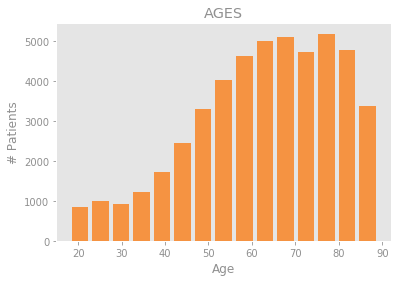

In [0]:
# Plot - total
ages_df.hist(column='AGES', bins=15, color='#f59342', grid=False, zorder=2, rwidth=0.8)
plt.xlabel('Age')
plt.ylabel('# Patients')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f63d6fa1b00>,
      dtype=object)

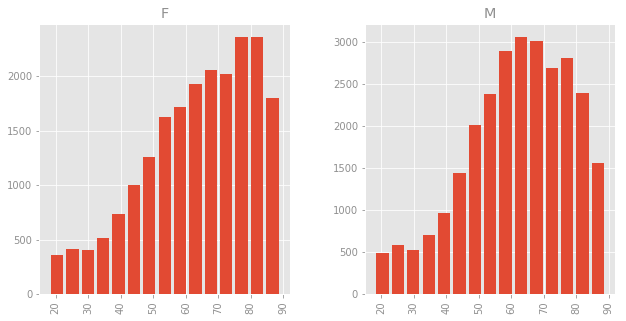

In [0]:
# Plots - by gender
ages_df.hist(column='AGES', by='GENDER', bins=15, grid=False, zorder=2, rwidth=0.8, figsize=(10, 5))

### INSURANCE

In [0]:
# Count unique non-NA observations
# insurance = mimic_admission_df.groupby('INSURANCE')['SUBJECT_ID'].nunique()

# Count non-NA observations
insurance = mimic_admission_df.groupby('INSURANCE')['SUBJECT_ID'].count()
insurance.sort_values(ascending=False)

INSURANCE
Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: SUBJECT_ID, dtype: int64

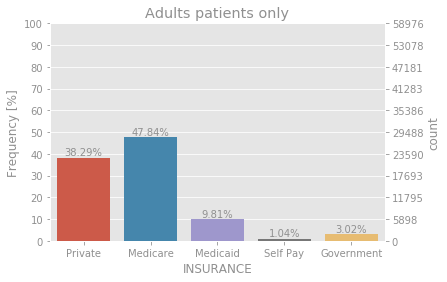

In [0]:
countplot_frenquency(mimic_admission_df, 'INSURANCE', 'Adults patients only')

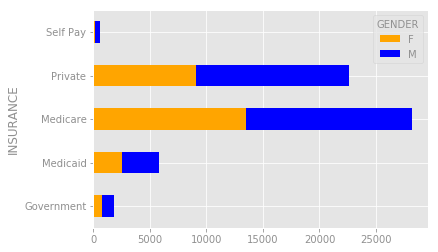

In [0]:
ap.groupby(['INSURANCE','GENDER']).size().unstack().plot(kind="barh", stacked=True, color=['orange', 'blue'])

In [0]:
# Stacked bar plot with two-level groupby, percentages normalized to 100%

# ap.groupby(['INSURANCE','GENDER']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()
#                                                                 ).unstack().plot(kind='bar', stacked=True, 
#                                                                                  color=['orange', 'blue'])
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.show()

Text(0, 0.5, 'Density')

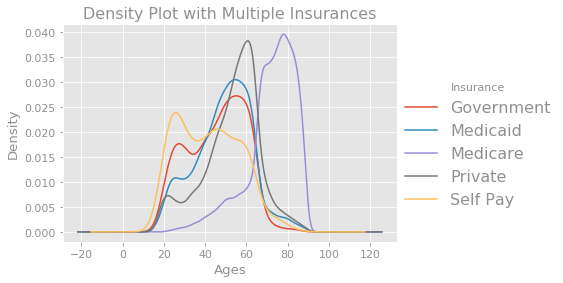

In [0]:
# Insurance by age
ages_df.groupby('INSURANCE')['AGES'].plot(kind='density')

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Insurance', frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title('Density Plot with Multiple Insurances')
plt.xlabel('Ages')
plt.ylabel('Density')

#### Medicare:

"*Medicare is a national health insurance program in the United States, begun in 1966 under the 
Social Security Administration (SSA) and now administered by the Centers for Medicare and Medicaid Services (CMS). 
It provides health insurance for Americans aged 65 and older, younger people with some disability status as 
determined by the Social Security Administration, as well as people with end stage renal disease and amyotrophic 
lateral sclerosis (ALS or Lou Gehrig's disease).*"

Source: https://en.wikipedia.org/wiki/Medicare_(United_States)

#### Medicaid:

"*Medicaid in the United States is a federal and state program that helps with medical costs for some people with 
limited income and resources. Medicaid also offers benefits not normally covered by Medicare, including nursing 
home care and personal care services. The Health Insurance Association of America describes Medicaid as 
"a government insurance program for persons of all ages whose income and resources are insufficient to pay for 
health care."*"

Source: https://en.wikipedia.org/wiki/Medicaid

### LANGUAGE

In [0]:
# Count unique non-NA observations
# language = mimic_admission_df.groupby(mimic_admission_df.LANGUAGE.str.strip("*"))['SUBJECT_ID'].nunique()

# Count non-NA observations
language = mimic_admission_df.groupby(mimic_admission_df.LANGUAGE.str.strip("*"))['SUBJECT_ID'].count()
language.sort_values(ascending=False).head()

LANGUAGE
ENGL    29086
SPAN     1083
RUSS      790
PTUN      628
CANT      413
Name: SUBJECT_ID, dtype: int64

There are 33644 admissions with language information (57% from total). English represents 65% of them.
Obs.: It's necessary to merge some of them due to the lack of pattern when answering this field.

In [0]:
# Amount of registered languages without merge
language.count()

75

### RELIGION


In [0]:
# Count unique non-NA observations
# religion = mimic_admission_df.groupby('RELIGION')['SUBJECT_ID'].nunique()

# Count non-NA observations
religion = mimic_admission_df.groupby('RELIGION')['SUBJECT_ID'].count()
religion.sort_values(ascending=False)

RELIGION
CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: SUBJECT_ID, dtype: int64

[Text(0, 0, 'CATHOLIC'),
 Text(0, 0, 'NOT SPECIFIED'),
 Text(0, 0, 'UNOBTAINABLE'),
 Text(0, 0, 'PROTESTANT QUAKER'),
 Text(0, 0, 'JEWISH')]

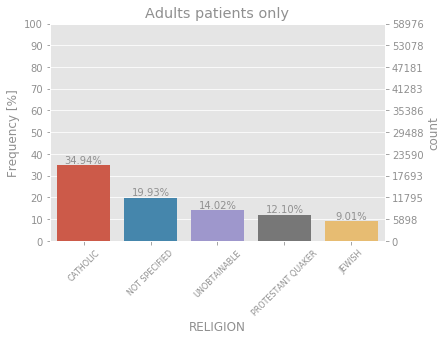

In [0]:
rel = mimic_admission_df.groupby(['RELIGION']).count()['ROW_ID']
# rel.sort_values(ascending=False).plot(kind = 'bar', color='green')

# Plotting only 5 
ax = countplot_frenquency(mimic_admission_df, 'RELIGION', 'Adults patients only', order=mimic_admission_df.RELIGION.value_counts().iloc[:5].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

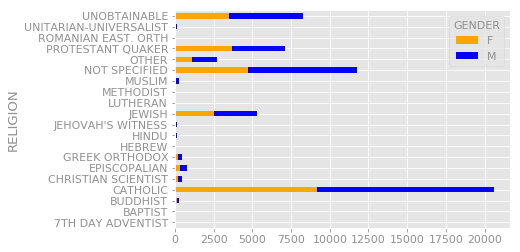

In [0]:
ap.groupby(['RELIGION','GENDER']).size().unstack().plot(kind="barh", stacked=True, color=['orange', 'blue'])

### MARITAL STATUS

In [0]:
# Count unique non-NA observations
# marital_st = mimic_admission_df.groupby('MARITAL_STATUS')['SUBJECT_ID'].nunique()

# Count non-NA observations
marital_st = mimic_admission_df.groupby('MARITAL_STATUS')['SUBJECT_ID'].count()
marital_st.sort_values(ascending=False)

MARITAL_STATUS
MARRIED              24239
SINGLE               13254
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: SUBJECT_ID, dtype: int64

[Text(0, 0, 'MARRIED'),
 Text(0, 0, 'SINGLE'),
 Text(0, 0, 'WIDOWED'),
 Text(0, 0, 'DIVORCED'),
 Text(0, 0, 'SEPARATED'),
 Text(0, 0, 'UNKNOWN (DEFAULT)'),
 Text(0, 0, 'LIFE PARTNER')]

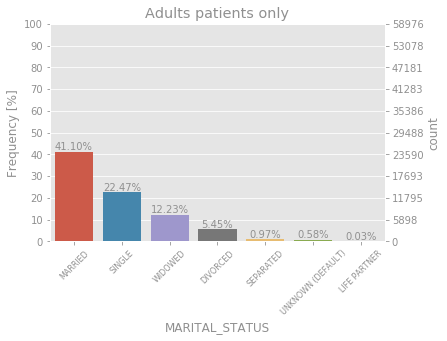

In [0]:
ax = countplot_frenquency(mimic_admission_df, 'MARITAL_STATUS', 'Adults patients only', order=mimic_admission_df.MARITAL_STATUS.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

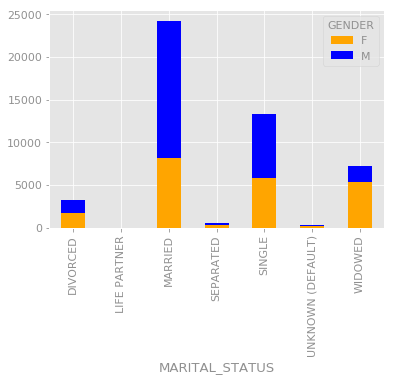

In [0]:
ap.groupby(['MARITAL_STATUS','GENDER']).size().unstack().plot(kind="bar", stacked=True, color=['orange', 'blue'])

### ETHNICITY

In [0]:
# Count unique non-NA observations
# ethnicity = mimic_admission_df.groupby('ETHNICITY')['SUBJECT_ID'].nunique()

# Count unique non-NA observations
ethnicity = mimic_admission_df.groupby('ETHNICITY')['SUBJECT_ID'].count()
ethnicity

ETHNICITY
AMERICAN INDIAN/ALASKA NATIVE                                  51
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE        3
ASIAN                                                        1509
ASIAN - ASIAN INDIAN                                           85
ASIAN - CAMBODIAN                                              17
ASIAN - CHINESE                                               277
ASIAN - FILIPINO                                               25
ASIAN - JAPANESE                                                7
ASIAN - KOREAN                                                 13
ASIAN - OTHER                                                  17
ASIAN - THAI                                                    4
ASIAN - VIETNAMESE                                             53
BLACK/AFRICAN                                                  44
BLACK/AFRICAN AMERICAN                                       5440
BLACK/CAPE VERDEAN                                            200


In [0]:
ethinicity_dict = ethnicity.to_dict()

sum_white = sum([value for key, value in ethinicity_dict.items() if 'WHITE' in key])
print("WHITE: " + str(sum_white))
sum_black = sum([value for key, value in ethinicity_dict.items() if 'BLACK' in key])
print("BLACK: " + str(sum_black))
sum_asian = sum([value for key, value in ethinicity_dict.items() if 'ASIAN' in key])
print("ASIAN: " + str(sum_asian))
sum_latino = sum([value for key, value in ethinicity_dict.items() if 'LATINO' in key])
print("LATINO: " + str(sum_latino))
print("OTHER: 1512\nUNKNOWN/NOT SPECIFIED: 4523")

WHITE: 41325
BLACK: 5785
ASIAN: 2007
LATINO: 2128
OTHER: 1512
UNKNOWN/NOT SPECIFIED: 4523


There were 41325 admissions from white people. This represents 70% from total. Blacks represent only 9,8%, followed by unknown (7,7%), asians and latinos (~3,5%).

#### Example 

In [0]:
# Select
mimic_admission_df.loc[(mimic_admission_df['SUBJECT_ID'] == 109) & (mimic_admission_df['HADM_ID'] == 172335)]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
172,128,109,172335,2141-09-18 10:32:00,2141-09-24 13:53:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,2141-09-18 07:06:00,2141-09-18 11:25:00,LEG PAIN,0,1


### 3. DIAGNOSES AND ICD9 CODES TABLES

International Classification of Diseases (ICD). 
ICD-9 codes corresponding to the diagnosis assigned to the patient for the given row.

In [0]:
# Drive path
mimic_diagnoses_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/DIAGNOSES_ICD.csv')

# Local path
# mimic_diagnoses_df = pd.read_csv(io.BytesIO(uploaded['DIAGNOSES_ICD.csv']))

mimic_diagnoses_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [0]:
# Drive path
mimic_diagnoses_descriptions_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/D_ICD_DIAGNOSES.csv')

# Local path
# mimic_diagnoses_descriptions_df = pd.read_csv(io.BytesIO(uploaded['D_ICD_DIAGNOSES.csv']))

mimic_diagnoses_descriptions_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [0]:
diagnoses_icd9_count_dict = mimic_diagnoses_df['ICD9_CODE'].value_counts().to_dict()

diagnoses_icd9_count_dict2 = {}
for k, v in diagnoses_icd9_count_dict.items():
    row = mimic_diagnoses_descriptions_df.loc[(mimic_diagnoses_descriptions_df['ICD9_CODE'] == k)]
    diagnosis_description = row.get('LONG_TITLE').to_list()
    if diagnosis_description:
        diagnoses_icd9_count_dict2[diagnosis_description[0]] = v
    else: 
        diagnoses_icd9_count_dict2[k] = v

In [0]:
diagnoses_icd9_df = pd.DataFrame(list(diagnoses_icd9_count_dict2.items()), columns=['DIAGNOSIS', 'PATIENTS'])
diagnoses_icd9_df.head()

,DIAGNOSIS,PATIENTS
0,Unspecified essential hypertension,20703
1,"Congestive heart failure, unspecified",13111
2,Atrial fibrillation,12891
3,Coronary atherosclerosis of native coronary ar...,12429
4,"Acute kidney failure, unspecified",9119


#### Demographics and Diagnoses

In [0]:
mimic_patients_diagnoses_df = pd.merge(ages_df, mimic_diagnoses_df, on = 'SUBJECT_ID' , how = 'inner')
mimic_patients_diagnoses_df.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID_x,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,AGES,ROW_ID,HADM_ID_y,SEQ_NUM,ICD9_CODE
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,151,165315,1.0,9678
1,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,152,165315,2.0,9693
2,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,153,165315,3.0,E9502
3,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,154,165315,4.0,E9503
4,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,155,165315,5.0,3488


#### Diagnoses by Gender

In [0]:
gender_diagnoses = mimic_patients_diagnoses_df.groupby(['ICD9_CODE','GENDER']).size().unstack()
gender_diagnoses = gender_diagnoses.reset_index()
gender_diagnoses = gender_diagnoses.sort_values(by=['F', 'M'], ascending=False)

In [0]:
gender_diagnoses.insert(1, 'DIAGNOSIS', 'NULL')

In [0]:
# iterate over the dataframe row by row
for index_label, row_series in gender_diagnoses.iterrows():
   # For each row update 'Diagnosis' field
   row = mimic_diagnoses_descriptions_df.loc[(mimic_diagnoses_descriptions_df['ICD9_CODE'] == row_series.ICD9_CODE)]
   diagnosis_description = row.get('LONG_TITLE').to_list()
   if diagnosis_description:
    gender_diagnoses.at[index_label, 'DIAGNOSIS'] = diagnosis_description[0]

In [0]:
gender_diagnoses

GENDER,ICD9_CODE,DIAGNOSIS,F,M
1928,4019,Unspecified essential hypertension,16010.0,18790.0
2074,4280,"Congestive heart failure, unspecified",13357.0,16009.0
2063,42731,Atrial fibrillation,9414.0,13552.0
2914,5849,"Acute kidney failure, unspecified",9027.0,10856.0
2984,5990,"Urinary tract infection, site not specified",8230.0,5255.0
810,25000,Diabetes mellitus without mention of complicat...,7521.0,9373.0
1984,41401,Coronary atherosclerosis of native coronary ar...,7369.0,14783.0
931,2724,Other and unspecified hyperlipidemia,7197.0,8954.0
2499,51881,Acute respiratory failure,7008.0,8072.0
2593,53081,Esophageal reflux,6584.0,6511.0


####Diagnoses by Ethnicity

In [0]:
# iterate over the dataframe row by row
for index_label, row_series in mimic_patients_diagnoses_df.iterrows():
  if 'WHITE' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'WHITE'
  elif 'BLACK' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'BLACK'
  elif 'HISPANIC/LATINO' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'HISPANIC/LATINO'
  elif 'ASIAN' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'ASIAN'
  elif 'AMERICAN' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'AMERICAN'

In [0]:
# by Ethnicity
eth_diagnoses = mimic_patients_diagnoses_df.groupby(['ICD9_CODE','ETHNICITY']).size().unstack(level=1)
eth_diagnoses = eth_diagnoses.reset_index()
eth_diagnoses = eth_diagnoses.sort_values(by='WHITE', ascending=False)

In [0]:
# Major ICD9 diagnoses for white patients
eth_diagnoses[["ICD9_CODE", "WHITE"]].dropna().iloc[:20]

ETHNICITY,ICD9_CODE,WHITE
1928,4019,24177.0
2074,4280,19413.0
2063,42731,17206.0
1984,41401,14251.0
2914,5849,12868.0
810,25000,10970.0
931,2724,10831.0
2499,51881,10211.0
2984,5990,9361.0
2593,53081,8807.0


In [0]:
# Major ICD9 diagnoses for black patients
eth_diagnoses[["ICD9_CODE", "BLACK"]].dropna().iloc[:20]

ETHNICITY,ICD9_CODE,BLACK
1928,4019,5185.0
2074,4280,5862.0
2063,42731,2433.0
1984,41401,4237.0
2914,5849,4468.0
810,25000,3085.0
931,2724,3161.0
2499,51881,2667.0
2984,5990,2276.0
2593,53081,2715.0


### 4. NOTE EVENTS CHART

Sample with 1% of total table lines

In [0]:
# Drive path
mimic_noteevents_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/sample_NOTEEVENTS.csv')

mimic_noteevents_df.head()

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,0,238,5136,151912.0,2189-12-10,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2189-12-1**] Dischar...
1,1,93,3506,170410.0,2195-07-07,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2195-6-29**] Dischar...
2,2,473,58242,168136.0,2201-09-15,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2201-8-28**] ...
3,3,411,9253,154196.0,2146-08-30,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2146-8-20**] ...
4,4,920,8258,106120.0,2112-09-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2112-9-8**] D...


In [0]:
# Discharge Summary from patient 5136 (SUBJECT_ID)
print(mimic_noteevents_df["TEXT"].loc[0])

Admission Date: [**2189-12-1**]        Discharge Date: [**2189-12-11**]

Date of Birth:  [**2123-2-13**]        Sex:  M

Service:  VSU


CHIEF COMPLAINT:  Chronic right ankle infection with unstable
joint.

HISTORY OF PRESENT ILLNESS:  This is a 66-year-old male with
a nonhealing right malleolar wound and fracture for the last
2 years who underwent a right ankle traction and open
reduction internal fixation. The patient has had multiple
admissions for wound infections and multiple IV antibiotic
courses. Most recent admission was [**2189-9-28**], for a
wound infection. The patient recently complained of a
temperature elevation on [**2189-11-30**], and now is to be
admitted to Dr.[**Name (NI) 1392**] service for continued IV
antibiotics. The patient initially was discharged on
daptomycin and followed by VNA.

PAST MEDICAL HISTORY:  Type 2 diabetes with triopathy,
endstage renal disease secondary to diabetes, status post
cadaver transplant in [**2182**], history of coronary artery
disease

In [0]:
# Search about pregnancy
mimic_noteevent_pregnancy_df = mimic_noteevents_df[mimic_noteevents_df['TEXT'].str.contains("pregnant")]
mimic_noteevent_pregnancy_df.iloc[:20]

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
228,228,31501,28305,144863.0,2173-08-08,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2173-7-28**] ...
294,294,39271,90019,134221.0,2156-09-19,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2156-9-14**] ...
3162,3162,316699,28067,169880.0,2115-03-28,2115-03-28 10:15:00,2115-03-28 10:14:30,Nursing,Nursing Transfer Note,19891.0,NaN,Ms. [**Known lastname 884**] is a 31 yo 34wk p...
3195,3195,314638,29200,105865.0,2142-02-21,2142-02-21 20:29:00,2142-02-21 21:36:11,Physician,Physician Resident Admission Note,17865.0,NaN,Chief Complaint: ARDS\n HPI:\n This is a ...
3197,3197,314698,29200,105865.0,2142-02-22,2142-02-22 12:37:00,2142-02-22 12:38:07,Case Management,Case Managment Initial Patient Assessment,15656.0,NaN,Insurance information\n Primary insurance: H...
6327,6327,621351,63079,170223.0,2104-03-24,2104-03-24 17:13:00,2104-03-24 17:13:53,Physician,Physician Attending Admission Note - MICU,17419.0,NaN,Chief Complaint: 31 yr woman G2P1 currently 1...
19218,19218,1903349,15950,149341.0,2154-02-12,2154-02-12 12:08:00,2154-02-12 12:37:00,Nursing/other,Report,14720.0,NaN,Social Work:\n\n This note reflects meeting he...


In [0]:
print(mimic_noteevent_pregnancy_df["TEXT"].loc[228])

Admission Date:  [**2173-7-28**]              Discharge Date:   [**2173-8-8**]

Date of Birth:  [**2139-9-7**]             Sex:   F

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 1666**]
Chief Complaint:
pancreatitis, hypercalcemia

Major Surgical or Invasive Procedure:
none

History of Present Illness:
33yo previously healthy female presents from OSH with severe
hypercalcemia, acute pancreatitis who is now POD #0 s/p
C-section delivery of healthy male.  She reports that she has
had ongoing mid-low back pain x several months which became
worse over the past few days.  She also noted increasing
epigastric pain associated with nausea and vomiting at home over
the past 1-2 days.  She has not been tolerating PO.  She denies
diarrhea, however.  No fevers/chills.  No sick contacts.  She
reports that the pain became so severe ([**10-6**]) overnight that
she went to the local ED for further evaluation.
.
At the OSH ED, initi

### 5. ICUSTAYS TABLE


In [0]:
# Drive path
mimic_diagnoses_descriptions_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/ICUSTAYS.csv')

# Local path
# mimic_icustays_df = pd.read_csv(io.BytesIO(uploaded['ICUSTAYS.csv']))

mimic_icustays_df.head()

In [0]:
mimic_icustays_df.groupby('FIRST_CAREUNIT')['SUBJECT_ID'].nunique()

### Pandas-Profiling

[Pandas-Profiling](https://github.com/pandas-profiling/pandas-profiling) is a Python library for exploratory data analysis

In [0]:
# !conda install -c conda-forge pandas-profiling -y
import pandas_profiling

# ignore the times when profiling since they are uninteresting
cols = [c for c in mimic_admission_df.columns if not c.endswith('TIME')]
pandas_profiling.ProfileReport(mimic_admission_df[cols])

### Missingno
[Missingno](https://github.com/ResidentMario/missingno) offers a visual summary of the completeness of a dataset.

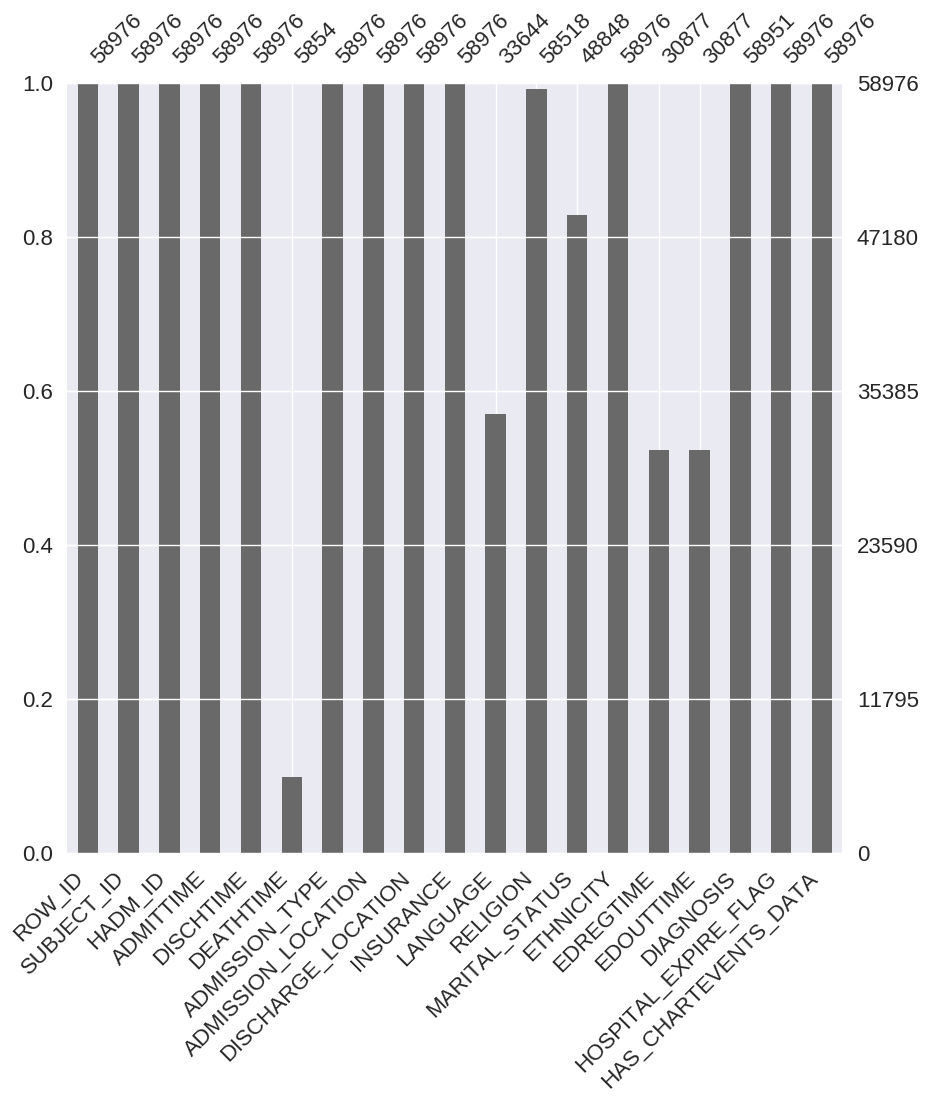

In [150]:
# !conda install -c conda-forge missingno -y
import missingno as msno
msno.bar(mimic_admission_df, figsize=(10,10))